In [22]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import kornia
import torch

# Taughts
- Get the people out to way, since they are most feature in the feature detection system. -> Use 
image segmentation.
- Use Midas to get the depth segmentation.
- Use the Kornia to extract features.
- Compare the fundamental matrix comparision between old and new images.


## Image Segmentation

In [145]:

from detectron2 import model_zoo
from detectron2.engine.defaults import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from kornia_moons.feature import *

In [18]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_2d9806.pkl: 431MB [03:24, 2.11MB/s]                              


In [89]:
def predict_and_overlay(model, filename):
    # helper method to run the model on an image and overlay the predictions
    im = cv2.imread(filename)
    out = model(im)
    print(im.shape)
    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    instance = out["instances"].to("cpu")
    boxes = out['instances'].pred_boxes.to("cpu")
    print(boxes.tensor.numpy())
    # print(instance[0]["pred_masks"].to("cpu"))
    out = v.draw_instance_predictions(out["instances"].to("cpu"))
    print(out.get_image().shape)
    plt.figure(figsize=(16,12))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.tight_layout()

(687, 1041, 3)
[[ 531.11273  403.31146  583.0738   556.14044]
 [ 882.35144  398.03046  929.91785  527.3723 ]
 [ 431.43436  403.26562  480.17355  555.0016 ]
 [ 974.6601   426.2708  1040.9541   588.78314]
 [ 835.8712   406.39944  874.15314  490.2299 ]
 [ 935.425    389.4776   986.60815  513.85675]
 [ 475.81662  431.98148  523.0955   554.0545 ]
 [ 767.11884  407.43393  798.4237   470.7249 ]
 [ 794.18976  408.63907  824.5019   471.949  ]
 [ 810.96936  403.7685   844.3888   414.21796]
 [ 944.29877  484.059    989.6516   531.6404 ]
 [ 587.5186   408.7952   608.8709   474.3881 ]
 [ 383.7613   382.38025  392.70557  408.76086]
 [ 425.02008  410.1335   440.73093  443.9533 ]
 [ 626.20776  404.73752  643.40515  450.64807]
 [ 641.13477  406.13547  658.11786  452.31747]
 [ 753.5491   409.9619   766.65985  444.8675 ]
 [ 661.71326  402.76306  674.55365  442.08972]
 [1007.6865   406.1314  1040.7626   497.35556]
 [ 703.7454   417.29492  714.97955  445.04892]
 [ 856.959    407.61584  873.1099   454.7578 

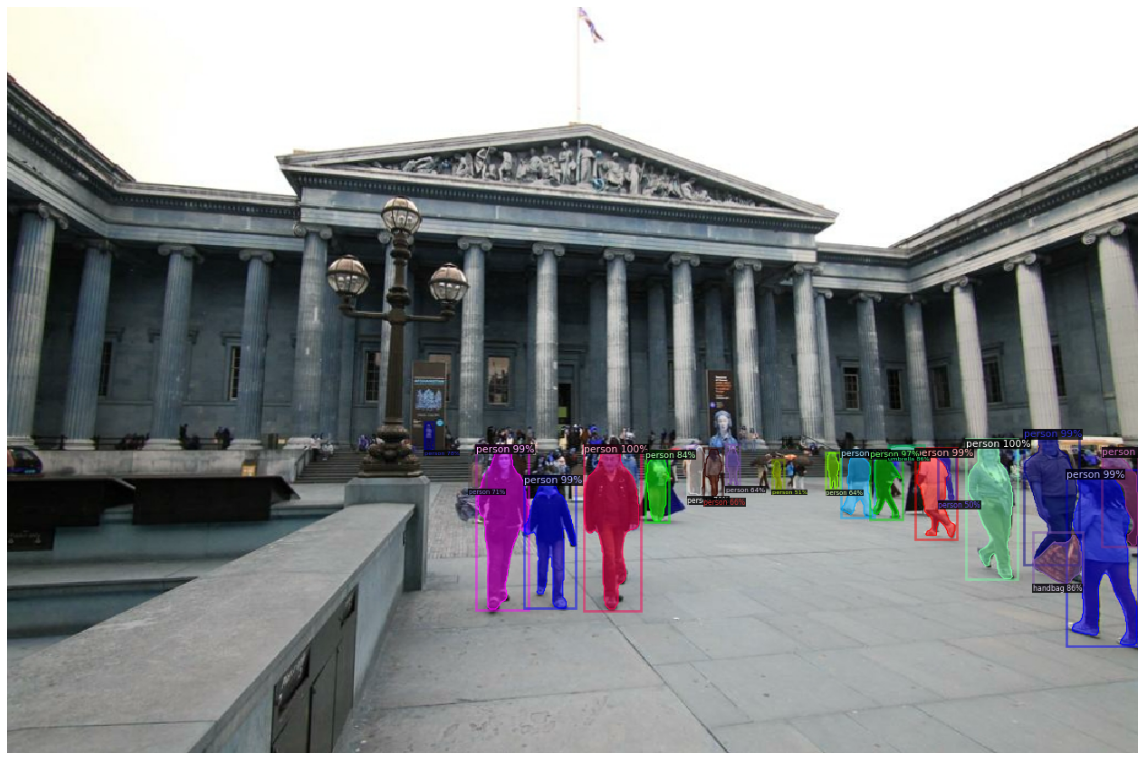

In [90]:
# loop through the dataset 
filename = 'data/train/british_museum/images/00742386_5921667484.jpg'
predict_and_overlay(predictor, filename)

## Midas depth segmentation

In [24]:
model_type ="DPT_Large"
midas = torch.hub.load("intel-isl/MiDas", model_type)

Using cache found in /home/prakyath/.cache/torch/hub/intel-isl_MiDas_master
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /home/prakyath/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt
100%|██████████| 1.28G/1.28G [00:16<00:00, 81.7MB/s]


In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=4

In [27]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /home/prakyath/.cache/torch/hub/master.zip


In [28]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [29]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

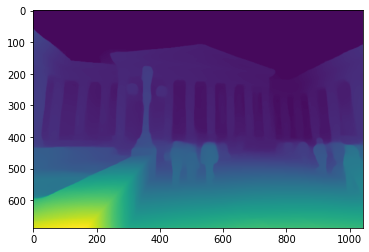

In [30]:
plt.imshow(output)

## Kornia feature extraction

In [139]:

# loading the feature extractor
# matcher = kornia.feature.LoFTR()
matcher = kornia.feature.LocalFeatureMatcher(
    kornia.feature.KeyNetAffNetHardNet(), kornia.feature.DescriptorMatcher()
)
matcher = kornia.feature.LocalFeatureMatcher(
    kornia.feature.SIFTFeature(), kornia.feature.DescriptorMatcher()
)
matcher.to(device).eval()


# loading the images
def load_torch_image(fname, device: torch.device = 'cuda'):
    img = cv2.imread(fname)
    scale = 840 / max(img.shape[0], img.shape[1]) 
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    img = kornia.image_to_tensor(img, False).float() /255.
    img = kornia.color.bgr_to_rgb(img)
    return img.to(device)
    

In [140]:

files = ['data/train/british_museum/images/00742386_5921667484.jpg', 
        'data/train/british_museum/images/01858319_78150445.jpg']
# pair = file

image_1 = load_torch_image('data/train/british_museum/images/00742386_5921667484.jpg')
# image_2 = load_torch_image('data/train/british_museum/images/01858319_78150445.jpg')
image_2 = load_torch_image(files[1])
# print(image_2)
input_dict = {"image0": kornia.color.rgb_to_grayscale(image_1), 
            "image1": kornia.color.rgb_to_grayscale(image_2)}

with torch.no_grad():
    correspondences = matcher(input_dict)
    # print(correspondences)
mkpts0 = correspondences['keypoints0'].cpu().numpy()
mkpts1 = correspondences['keypoints1'].cpu().numpy()
F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.99999, 100000)
print(F)

[[-2.52914535e-06  2.09219794e-05 -1.78607591e-03]
 [-2.76983182e-05 -9.63969011e-06  1.88805927e-02]
 [ 1.27623027e-02 -1.76571014e-02 -5.14163134e+00]]


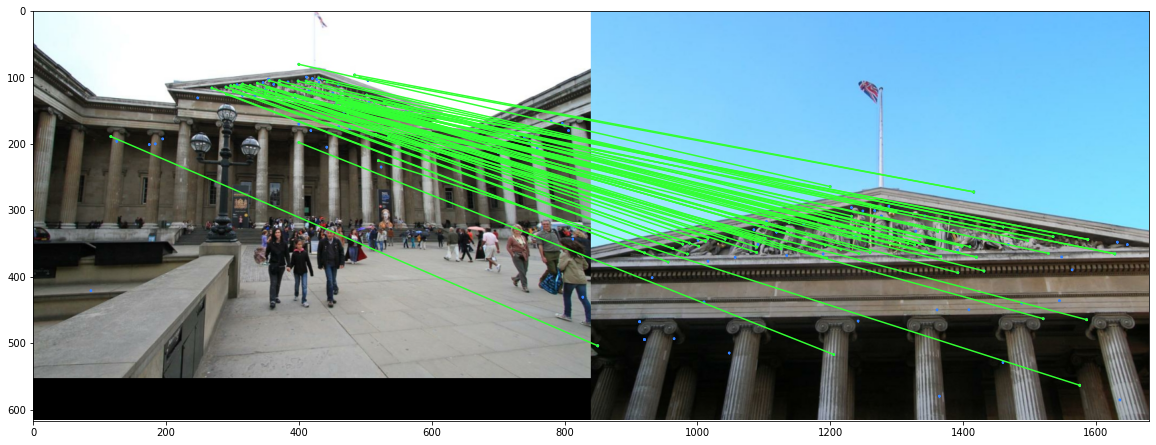

In [149]:
# plotting features
draw_LAF_matches(
kornia.feature.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                            torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                            torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

kornia.feature.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                            torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                            torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
kornia.tensor_to_image(image_1),
kornia.tensor_to_image(image_2),
inliers,
draw_dict={'inlier_color': (0.2, 1, 0.2),
            'tentative_color': None, 
            'feature_color': (0.2, 0.5, 1), 'vertical': False})

## Checking the fundamental matrix for the given images

In [141]:
import pandas as pd
f_matrix = pd.read_csv('data/train/british_museum/pair_covisibility.csv')


In [142]:
test_funda = files[1].split('/')[-1].split('.')[0] + '-' + files[0].split('/')[-1].split('.')[0]
F_actual  = f_matrix[test_funda == f_matrix['pair']]['fundamental_matrix'].to_list()

In [143]:
print(f'F_actual: {F_actual}')
print(f'F_predicted: {F.flatten()}')

F_actual: ['1.23352155e-01 -4.65513901e+00 5.71776017e+03 4.09264634e+00 -3.87955405e+00 -7.75342903e+03 -1.84854904e+03 6.46342936e+03 -2.67618053e+06']
F_predicted: [-2.52914535e-06  2.09219794e-05 -1.78607591e-03 -2.76983182e-05
 -9.63969011e-06  1.88805927e-02  1.27623027e-02 -1.76571014e-02
 -5.14163134e+00]


## Taughts on the just the feature extraction